# Lung Image Segmentation Data Preprocessing and Model Training, Testing, and Prediction

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import numpy as np
import tensorflow as tf
import random as rn
import datetime
import matplotlib
from tqdm import tqdm
import cv2
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import image
np.random.seed(1234)
rn.seed(1234)

In [ ]:
directory = '/content/drive/My Drive/Colab Notebooks/Lung_disease_mini_project/'

# Data Loading

In [ ]:
train_x = np.load(directory+"/train_x.npy")  
print(train_x.shape)

train_y = np.load(directory+"/train_y.npy")
print(train_y.shape)

valid_x = np.load(directory+"/valid_x.npy")
print(valid_x.shape)

valid_y = np.load(directory+"/valid_y.npy")
print(valid_y.shape)

test_x = np.load(directory+"/test_x.npy")
print(test_x.shape)

test_y = np.load(directory+"/test_y.npy")
print(test_y.shape)

(396, 256, 256, 1)
(396, 256, 256, 1)
(113, 256, 256, 1)
(113, 256, 256, 1)
(57, 256, 256, 1)
(57, 256, 256, 1)


# Image Preprocessing and Normalization

In [ ]:
train_x = train_x.astype('float32')
train_y = train_y.astype('float32')/255
train_y = (train_y > 0.5)

valid_x = valid_x.astype('float32')
valid_y = valid_y.astype('float32')/255
valid_y = (valid_y > 0.5)

test_x = test_x.astype('float32')
test_y = test_y.astype('float32')/255
test_y = (test_y > 0.5)

In [ ]:
mean = np.mean(train_x)
std = np.std(train_x)

print(mean)
print(std)

train_x -= mean
train_x /= std
valid_x -= mean
valid_x /= std
test_x -= mean
test_x /= std

157.0747
65.238914


# Unet Model

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
input_shape = (256, 256, 1)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Deep Residual Unet Model

In [ ]:
def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def build_resunet(input_shape):
    inputs = Input(input_shape)

    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same", strides=1)(inputs)
    s1 = x + s

    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    b = residual_block(s3, 512, strides=2)

    d1 = decoder_block(b, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs)
    return model

In [ ]:
model_1 = build_resunet((256, 256, 1))
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

# Compilation

In [ ]:
smooth=1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
import math

mc = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/_mini_unet.h5', monitor='val_loss', save_best_only=True)
cv = CSVLogger('/content/drive/My Drive/Colab Notebooks/unet.csv',separator=",", append=False)
es  = EarlyStopping(monitor='val_loss', min_delta=0, patience=250,  mode='auto')

In [ ]:
from keras import backend as K

optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.9, epsilon=None, decay=0.0, amsgrad=True)
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[dice_coef,'accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [ ]:
history = model_1.fit(train_x,train_y,batch_size=16, epochs=60,validation_data = (valid_x,valid_y),verbose=1,callbacks=[mc,cv,es],shuffle=True)

Epoch 1/60
25/25 [==============================] - 108s 3s/step - loss: 0.3600 - dice_coef: 0.7283 - accuracy: 0.8805 - val_loss: 0.4729 - val_dice_coef: 0.3678 - val_accuracy: 0.7694
Epoch 2/60
25/25 [==============================] - 63s 3s/step - loss: 0.1295 - dice_coef: 0.8556 - accuracy: 0.9521 - val_loss: 0.5088 - val_dice_coef: 0.3244 - val_accuracy: 0.7546
Epoch 3/60
25/25 [==============================] - 62s 3s/step - loss: 0.1040 - dice_coef: 0.8833 - accuracy: 0.9621 - val_loss: 0.4856 - val_dice_coef: 0.3252 - val_accuracy: 0.7260
Epoch 4/60
25/25 [==============================] - 63s 3s/step - loss: 0.0903 - dice_coef: 0.9009 - accuracy: 0.9670 - val_loss: 0.5033 - val_dice_coef: 0.3032 - val_accuracy: 0.7207
Epoch 5/60
25/25 [==============================] - 63s 3s/step - loss: 0.0828 - dice_coef: 0.9086 - accuracy: 0.9699 - val_loss: 0.4748 - val_dice_coef: 0.3658 - val_accuracy: 0.7492
Epoch 6/60
25/25 [==============================] - 63s 3s/step - loss: 0.0777 

# Visualization

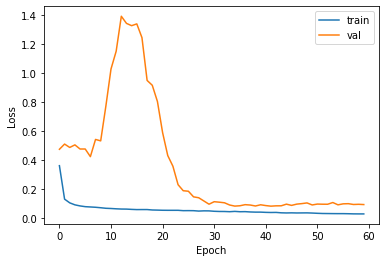

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
t_loss=range(len(train_loss))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(t_loss, train_loss)
plt.plot(t_loss, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

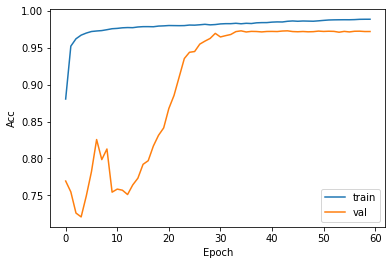

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(t_loss, train_acc)
plt.plot(t_loss, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

# Weights loading

In [ ]:
model_1.load_weights('/content/drive/My Drive/Colab Notebooks/_mini_unet.h5')

In [ ]:
!pip install medpy

     |████████████████████████████████| 151 kB 4.9 MB/s 
     |████████████████████████████████| 48.4 MB 32 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754431 sha256=40965782f87f1b4e6677fd6f78baffc56f16814929a37c5893c6e31fc86ed78f
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


In [ ]:
from medpy.metric import dc,precision

# Unet Model Results

In [ ]:
test_pred = model.predict(test_x, batch_size=32)
test_result = np.zeros(test_pred.shape)
test_result[test_pred>0.50] = 1
test_result[test_pred<=0.50] = 0
dice = dc(test_result, test_y)
pre  = precision(test_result,test_y)

Test dc: 0.9412376546297908
Test pre: 0.9583612746295123


# Deep Residual Unet Results

In [ ]:
test_pred = model_1.predict(test_x, batch_size=32)
test_result = np.zeros(test_pred.shape)
test_result[test_pred>0.50] = 1
test_result[test_pred<=0.50] = 0
dice = dc(test_result, test_y)
pre  = precision(test_result,test_y)
print('Test dc: '  + str(dice))
print('Test pre: ' + str(pre))

Test dc: 0.9593633546297434
Test pre: 0.9617935574908301


# Comparison of Test Prediction vs Test Images(ground truth) with mask (Deep Residual Unet)

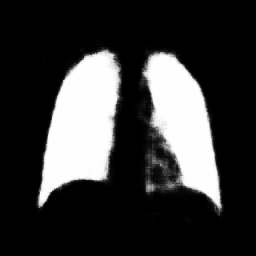

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(test_pred[21]*255)                         # Test prediction

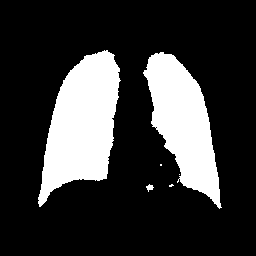

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(test_result[21]*255)                       # Test result (or Mask)

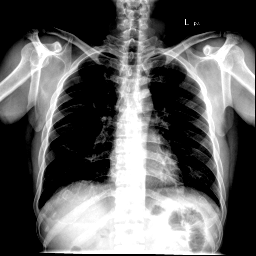

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(test_x[21]*255)                            # Tested image

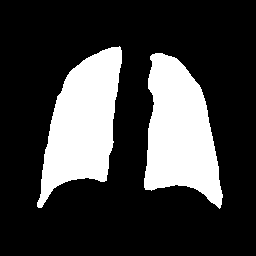

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(test_y[21]*255)                             # Tested mask

# Plotting some Test images with mask

In [ ]:
def plot(img,mask):
    plt.figure(figsize=(15,15))
    i=0
    j=0
    for k in range(16):
        plt.subplot(4,4,k+1)
        plt.axis('Off')
        if(k % 2 == 0):
          plt.title('Image '+str(i))
          plt.imshow(img[i])
          i+=1
        else:
          plt.title('Mask '+str(j))
          plt.imshow(mask[j])
          j+=1

In [ ]:
test_x = np.squeeze(test_x)
test_y = np.squeeze(test_y)

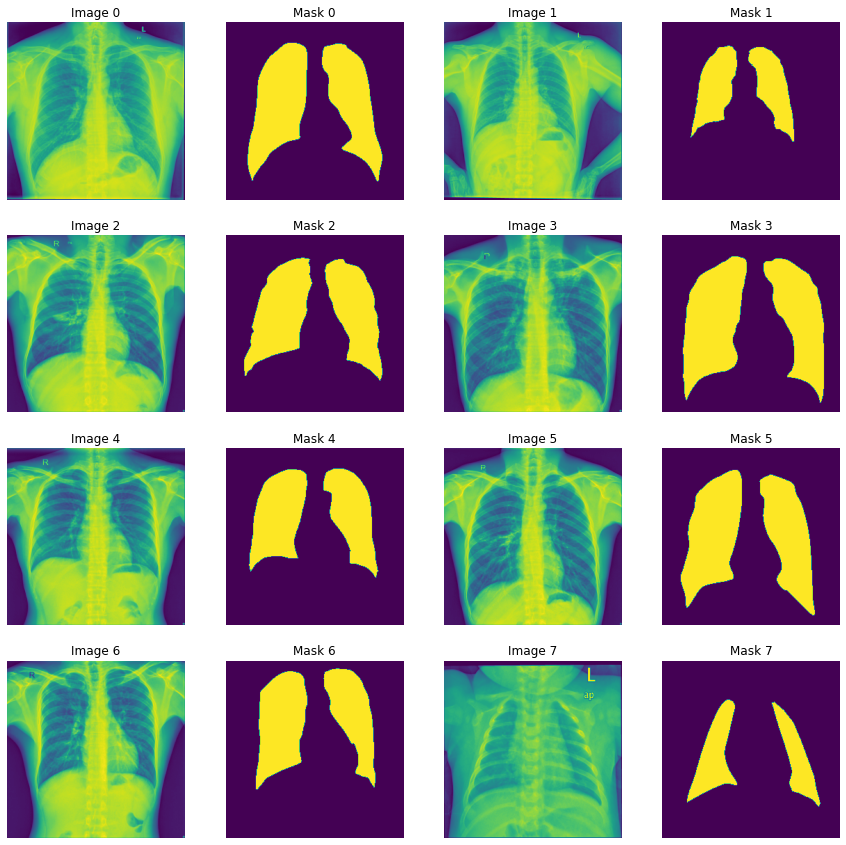

In [ ]:
import matplotlib.pyplot as plt

plot(test_x, test_y)

# Plotting some Predicted mask images with their equivalent mask

In [ ]:
test_pred = np.squeeze(test_pred)
test_result = np.squeeze(test_result)

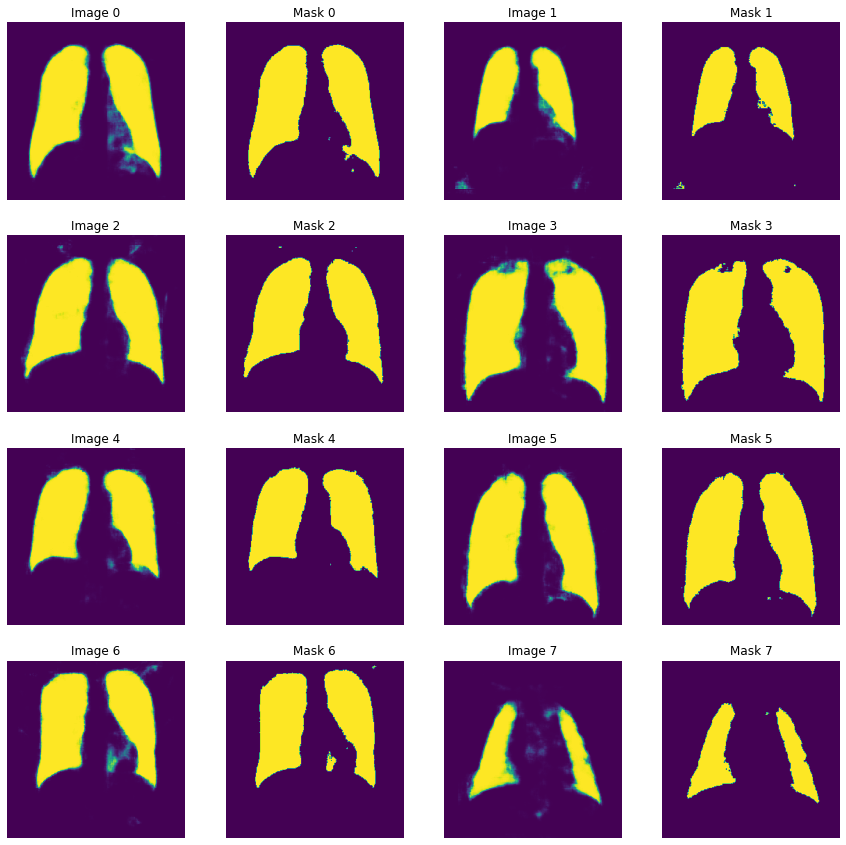

In [ ]:
plot(test_pred, test_result)